# Clasificación de fallos a partir de las mediciones de fuerza y torque de un robot a lo largo del tiempo debidas al desgaste mecánico, errores del sensor, errores de calibración, fallos de software, sobrecarga, etc..

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

In [5]:
download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

In [9]:
df_ts.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


El dataset está formado por la columna time y 6 columnas de series temporales con señales de los sensores. La variable target y es true o false de si ha habido un error o no.

Ahora imputamos valores missing y seleccionamos las variables según su relación con la variable target.

In [10]:
extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]
C:\Users\TROPIBIO\mambaforge\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_z__partial_autocorrelation__lag_7'
 'F_z__partial_autocorrelation__lag_8'
 'F_z__partial_autocorrelation__lag_9' ...
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_y__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_y__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Otra forma de seleccionar las variables 

In [11]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.29it/s]
C:\Users\TROPIBIO\mambaforge\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]


Buscamos el mejor número de vecinos haciendo una Grid Search

In [21]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]})

In [13]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

C:\Users\TROPIBIO\AppData\Local\Temp\ipykernel_58336\60800978.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 99)` for the same effect.

  sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)


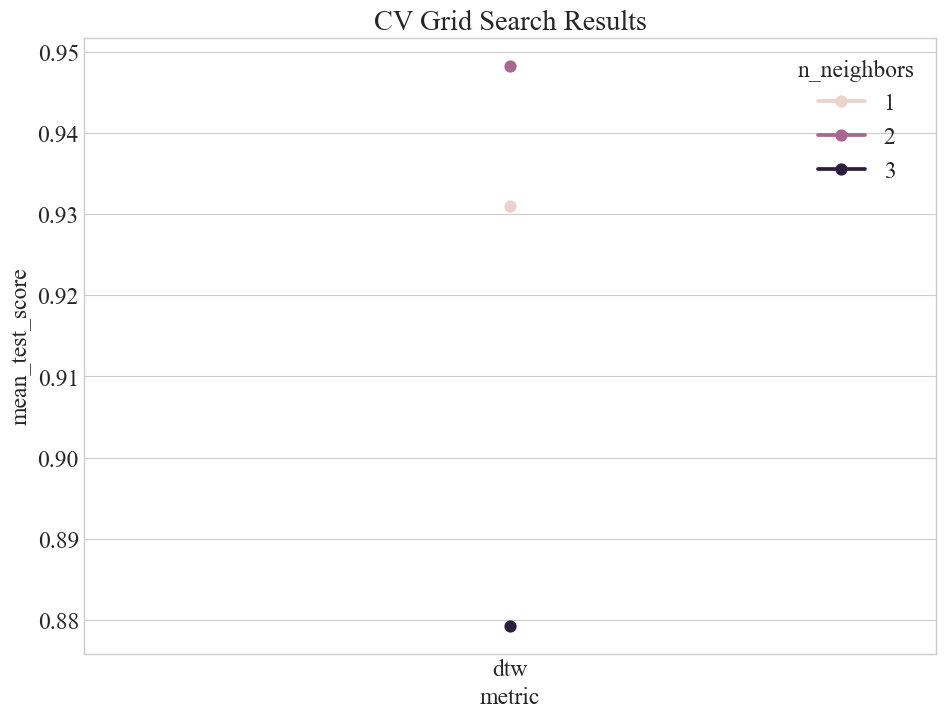

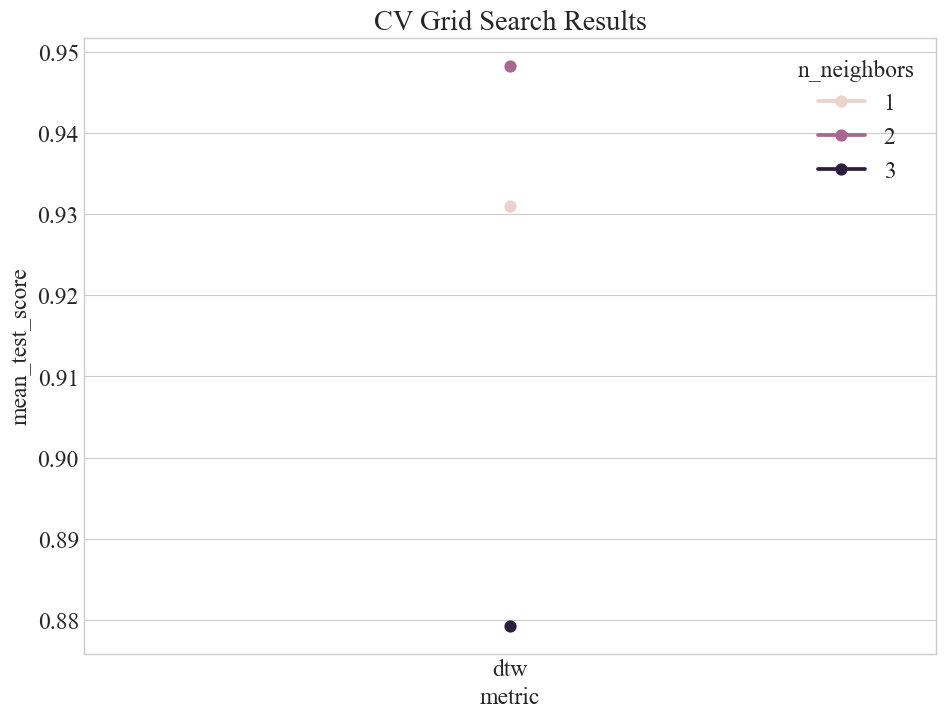

In [14]:
plot_cv_results(gsearch.cv_results_, 'metric', 'n_neighbors')

Según la distancia dynamic time warping el mejor número de vecinos serían 2